**Линейная регрессия и регуляризация**

* Обучии модель линейной регрессии на полиномиальных признаках.
* Построим линейную регрессию с L1-регуляризацией(Lasso) на полиномиальных признаках.
* Построим линейную регрессию с L2-регуляризацией на полиномиальных признаках.

In [ ]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
%matplotlib inline
plt.style.use('seaborn-v0_8')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('drive/MyDrive/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
print(data.shape)

(1338, 7)


In [ ]:
# Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
# Посмотрим на типы данных:

data.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


Избавимся от категорий, чтобы могли обучить модель:

In [ ]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (1070, 9)
Test: (268, 9)


In [ ]:
# Обучим модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных.
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Сделаем предсказание и рассчитаем метрики

def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))


y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Test MAPE: 47


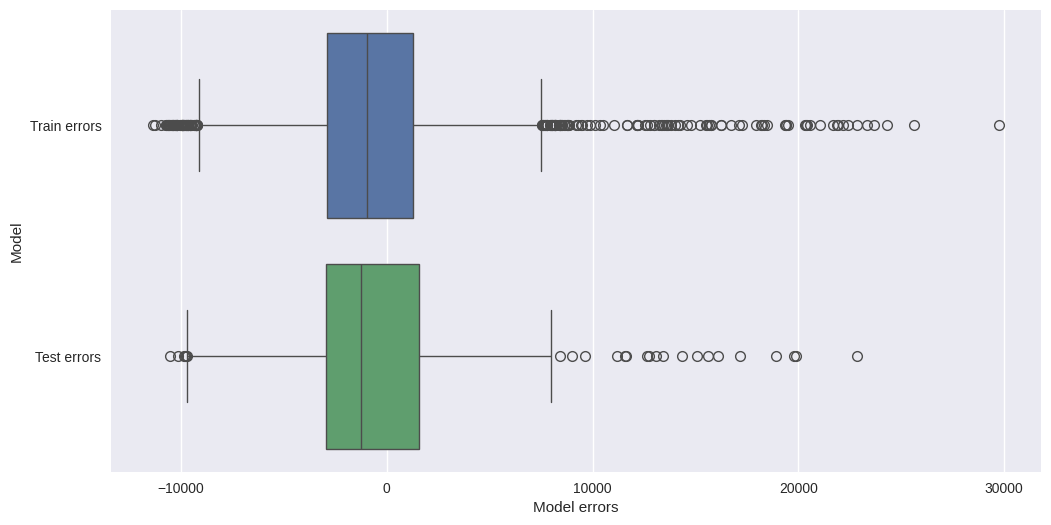

In [ ]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке
y_train_errors = y_train - lr_model.predict(X_train)
#Ошибки модели на тестовой выборке
y_test_errors = y_test - lr_model.predict(X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors,
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат



*   Разброс ошибок на тренировочной выборке больше, чем на тестовой.
*   Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).



Нормализуем тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler).

Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.
На нормализованных данных сгенерируем полиномиальные признаки степени 2. Воспользуемся классом PolynomialFeatures из библиотеки sklearn.

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

(1070, 54)


In [ ]:
#1 создаем модель лин. регрессии и обучаем ее на полином. признаках

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled_poly, y_train)

LinearRegression()

In [ ]:
# посмотрим на метрики:

y_train_predict = lr_model.predict(X_train_scaled_poly)
y_test_predict = lr_model.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2915
Train MAPE: 30


Test R^2: 0.867
Test MAE: 2748
Test MAPE: 31


Видим, что значения метрик улучшились, в сравнении с обучением на обычных признаках

Модель не переобучилась

Посмотрим на коэф-ы модели

In [ ]:
# 2

np.round(lr_model.coef_, 3)

array([-6.13187729e+16,  8.41033718e+14,  5.83238304e+15, -1.13904139e+16,
       -6.00962542e+13,  9.58667470e+14,  7.01129182e+14,  4.04850498e+14,
        1.29733639e+15,  8.36800000e+03,  8.56000000e+02,  1.06800000e+03,
       -1.65600000e+03,  1.64000000e+02,  6.13187729e+16,  6.13187729e+16,
        6.13187729e+16,  6.13187729e+16, -9.22451557e+13,  6.59500000e+02,
       -1.23675000e+03,  2.44250000e+02, -7.48788562e+14, -7.48788562e+14,
       -7.48788562e+14, -7.48788562e+14, -9.70562500e+03,  1.55137500e+03,
        5.48453120e+04, -5.83238304e+15, -5.83238304e+15, -5.83238304e+15,
       -5.83238304e+15, -2.13100000e+03, -2.23400000e+03,  1.13904139e+16,
        1.13904139e+16,  1.13904139e+16,  1.13904139e+16,  1.31600009e+14,
       -7.15037545e+13, -7.15037545e+13, -7.15037545e+13, -7.15037545e+13,
        5.94260639e+14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.51798927e+14,  0.00000000e+00,  0.00000000e+00,  1.14807761e+15,
        0.00000000e+00,  

Коэф-ы выглядят "плохо" - высокие степени

Применим регуляризацию, чтобы это исправить:

In [ ]:
#3

lasso_lr_poly = linear_model.Lasso(max_iter=2000)
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
y_train_predicted_poly = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predicted_poly = lasso_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predicted_poly, y_test, y_test_predicted_poly)

Train R^2: 0.842
Train MAE: 2890
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2719
Test MAPE: 30


Удалось незначительно понизить ошибки MAE, MAPE

In [ ]:
print(np.round(lasso_lr_poly.coef_, 3))

[ 3.2422170e+03 -4.9231400e+02  5.0761230e+03  4.5836210e+03
  1.9792860e+03  1.8802600e+02 -4.7077500e+02  5.8365700e+02
 -2.4354300e+02  8.2982680e+03  7.7458200e+02  8.4444900e+02
 -1.2077570e+03  1.3481000e+02 -1.0430970e+03 -0.0000000e+00
  1.1696420e+03  1.6176560e+03 -0.0000000e+00  5.0584800e+02
 -1.1342520e+03  2.6579700e+02 -1.2224050e+03  0.0000000e+00
  2.3621300e+02 -5.8003100e+02 -8.1796330e+03  1.2948780e+03
  5.4714855e+04  3.5853190e+03  2.4069020e+03 -9.6354900e+02
  0.0000000e+00 -1.6746430e+03 -2.0543650e+03  1.9420490e+03
  1.9539440e+03 -0.0000000e+00 -1.0636440e+03  8.0060000e+00
  5.9368900e+02 -0.0000000e+00 -2.3064300e+02  1.9793350e+03
  6.3161600e+02  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -6.0600000e-01]


Зато теперь коэффициенты, а именно их степени, выглядят гораздо лучше: степени понизились в несколько раз

In [ ]:
#4

ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
y_train_predicted_poly = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predicted_poly = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predicted_poly, y_test, y_test_predicted_poly)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Test MAPE: 31


Получили результат чуть хуже, чем в случае с L1-регуляризацией. Это связано с тем, что L1 регуляризация может занулять веса малоинформативных признаков

In [ ]:
print(np.round(ridge_lr_poly.coef_, 3))

[ 3369.384  -457.596  3655.824  3198.9    2682.622   199.057  -228.717
   191.947  -162.287  7548.511   581.668   935.504  -681.521   663.454
  -450.922   438.636  1406.726  1974.943  -457.596   947.623  -902.744
   739.02   -822.632   302.526   351.608  -289.098 -4274.118  2734.556
 44541.214  3667.338  1719.646 -1249.792  -481.368 -1314.966 -2172.723
  2171.56   1997.182   112.648 -1082.491  2682.622    94.233  -208.06
   535.717  2260.732   199.057     0.        0.        0.     -228.717
     0.        0.      191.947     0.     -162.287]


Получили похожие коэффициенты, однако без каких-либо занулений засчет регуляризации

In [ ]:
#5

#Создаём список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.001, 2, 40)
#Создаём пустые списки, в которые будем добавлять результаты
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=100000000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

test_scores

[0.8665833586935017,
 0.8665969984566078,
 0.8666103932626019,
 0.866623532918561,
 0.8666364403291262,
 0.8666491552973906,
 0.866661659515394,
 0.8666738237136693,
 0.8666858517018384,
 0.8666977119266364,
 0.866709251021276,
 0.8667205418725976,
 0.8667317057496773,
 0.8667423155541214,
 0.8667530622882571,
 0.8667635118181967,
 0.8667733698311226,
 0.866783456592629,
 0.8667930651159695,
 0.8668025127981684,
 0.866811831025747,
 0.8668208764876788,
 0.8668295331604281,
 0.8668382113614774,
 0.8668465992001617,
 0.866854327324579,
 0.8668620710094088,
 0.866870109192355,
 0.8668771638938677,
 0.8668846444471177,
 0.86689130233343,
 0.8668980732613462,
 0.8669042656092315,
 0.8669108785271384,
 0.8669166453772001,
 0.8669226560736498,
 0.8669282624376664,
 0.8669333150228455,
 0.8669383904535847,
 0.8669433973240476]

In [ ]:
maxi = -1
maxind = 0

for i in range(len(test_scores)):
  if test_scores[i] > maxi:
    maxi = test_scores[i]
    maxind = i

print(maxi, maxind)

0.8669433973240476 39


In [ ]:
print(len(test_scores))

40


Не удалось найти оптимальное значение alpha, так как оно с увеличением увеличивает значение метрик